$$ \text{Go to CentralDogma/2\_Lust\_/seperationSig}
$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

import lmfit
from lmfit.lineshapes import gaussian2d
from lmfit.models import LorentzianModel

In [5]:
cname = [['RAJ2000','DEJ2000'], ['ra_2a','dec_2a'], ['RAdeg', 'DEdeg'], ['RA_ICRS','DE_ICRS']]
fitrange=60
grid=101
weight=0.9

data = pd.read_csv('./CentralDogma/2_Lust_/3-IRAS_fsc-allsky.csv')

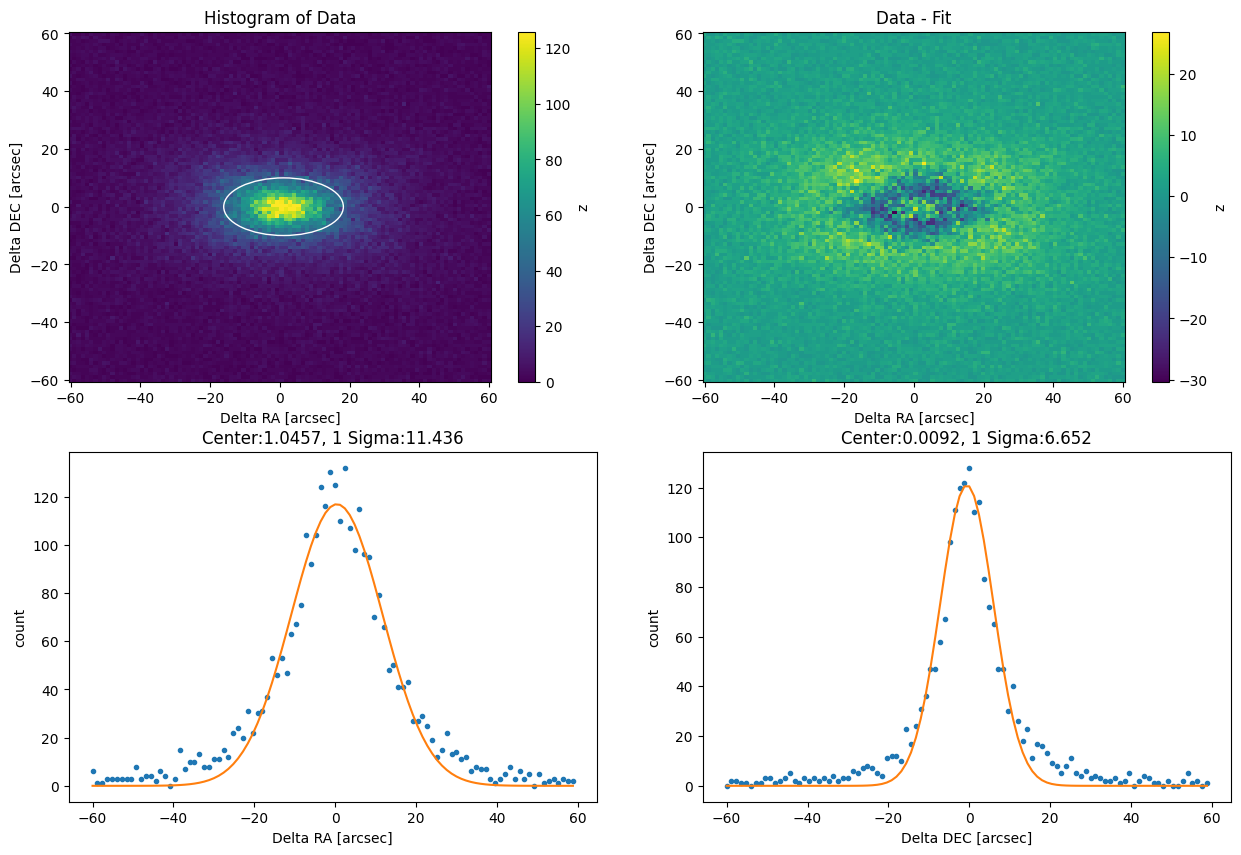

In [6]:

n1 = cname[1][0]
n2 = cname[1][1]

x = (data.RA-data[n1])
y = (data.DEC-data[n2])

x = (data.RA-data[n1])*3600*np.cos(data.DEC*np.pi/180)
y = (data.DEC-data[n2])*3600

xedges = np.linspace(-fitrange, fitrange, grid)
yedges = np.linspace(-fitrange, fitrange, grid)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
H = H.T
z = H.flatten()
X, Y = np.meshgrid(np.linspace(-fitrange, fitrange, grid-1), np.linspace(-fitrange, fitrange, grid-1))
xf = X.flatten()
yf = Y.flatten()
w = z**weight+0.1

model = lmfit.models.Gaussian2dModel()
params = model.guess(z, xf, yf)
result = model.fit(z, x=xf, y=yf, params=params, weights=w/10)
Amp = result.values['amplitude']
cenx = result.values['centerx']
sigx = result.values['sigmax']
ceny = result.values['centery']
sigy = result.values['sigmay']

Z = griddata((xf, yf), z, (X, Y), method='linear', fill_value=0)

fit = model.func(X, Y, **result.best_values)

Zx = Z[int((grid+1)/2)]
fitx = fit[int((grid+1)/2)]

Zy = Z.T[int((grid+1)/2)]
fity = fit.T[int((grid+1)/2)]

vmax = np.nanpercentile(Z, 99.9)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

ax = axs[0, 0]
art = ax.pcolor(X, Y, Z, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ell = Ellipse(
        (cenx, ceny),
        width = 3*sigx,
        height = 3*sigy,
        edgecolor = 'w',
        facecolor = 'none'
    )
ax.add_patch(ell)
ax.set_title('Histogram of Data')
ax.set_xlabel('Delta RA [arcsec]')
ax.set_ylabel('Delta DEC [arcsec]')

ax = axs[0, 1]
art = ax.pcolor(X, Y, Z-fit, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data - Fit')
ax.set_xlabel('Delta RA [arcsec]')
ax.set_ylabel('Delta DEC [arcsec]')

ax = axs[1, 0]
ax.plot(xedges[:100], Zx, marker='.', ls='')
ax.plot(xedges[:100], fitx)
ax.set_title('Center:{0:5.4f}, 1 Sigma:{1:5.3f}'.format(cenx, sigx))
ax.set_xlabel('Delta RA [arcsec]')
ax.set_ylabel('count')

ax = axs[1, 1]
ax.plot(yedges[:100], Zy, marker='.', ls='')
ax.plot(yedges[:100], fity)
ax.set_title('Center:{0:5.4f}, 1 Sigma:{1:5.3f}'.format(ceny, sigy))
ax.set_xlabel('Delta DEC [arcsec]')
ax.set_ylabel('count')

plt.show()

In [3]:
fig, ax = plt.subplots()

data = {
    'ra': ax.hist(x, grid)[1],
    'rac': ax.hist(x, grid+1)[0],
    'dec': ax.hist(y, grid)[1],
    'decc': ax.hist(y, grid+1)[0]
}

plt.close(fig)

dframe = pd.DataFrame(data=data)

model = LorentzianModel()

paramsx = model.guess(dframe['rac'], x=dframe['ra'])
paramsy = model.guess(dframe['decc'], x=dframe['dec'])

resultra = model.fit(dframe['rac'], paramsx, x=dframe['ra'])
cen1x = resultra.values['center']
sig1x = resultra.values['sigma']
resultdec = model.fit(dframe['decc'], paramsx, x=dframe['dec'])
cen1y = resultdec.values['center']
sig1y = resultdec.values['sigma']

Text(0, 0.5, 'count')

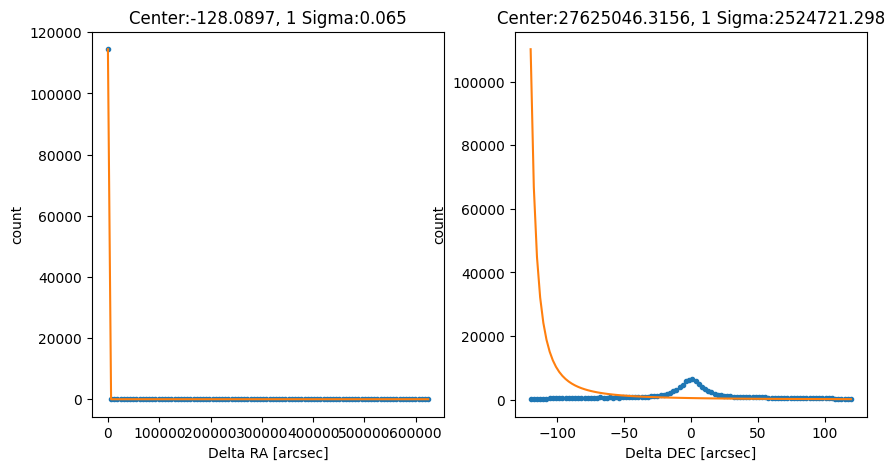

In [5]:
fitx = model.func(dframe['ra'], **resultra.best_values)
fity = model.func(dframe['dec'], **resultra.best_values)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
ax.plot(dframe['ra'], dframe['rac'], marker='.', ls='')
ax.plot(dframe['ra'], fitx)
ax.set_title('Center:{0:5.4f}, 1 Sigma:{1:5.3f}'.format(cen1x, sig1x))
ax.set_xlabel('Delta RA [arcsec]')
ax.set_ylabel('count')

ax = axs[1]
ax.plot(dframe['dec'], dframe['decc'], marker='.', ls='')
ax.plot(dframe['dec'], fity)
ax.set_title('Center:{0:5.4f}, 1 Sigma:{1:5.3f}'.format(cen1y, sig1y))
ax.set_xlabel('Delta DEC [arcsec]')
ax.set_ylabel('count')

In [50]:
len(ax.hist(x, 100)[1])

101

In [13]:
def gaussian(x, amp, cen, sig):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (np.sqrt(2*np.pi) * sig)) * np.exp(-(x-cen)**2 / (2*sig**2))

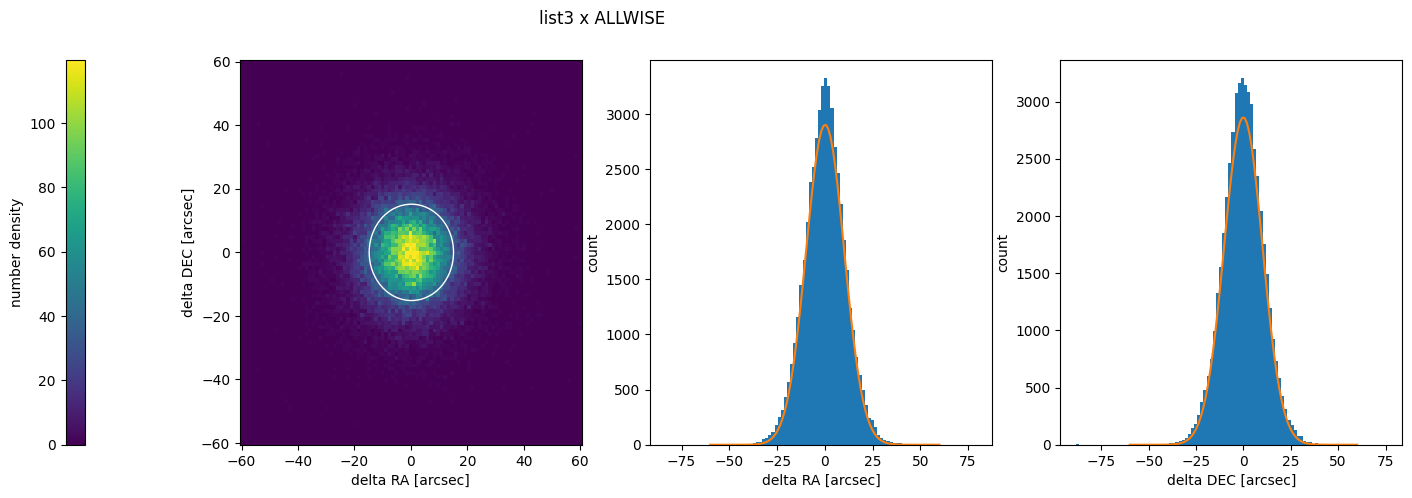

In [34]:
data = pd.read_csv('./CentralDogma/2_Lust_/3-ALLWISEv2.csv')

n1 = 'RAJ2000'
n2 = 'DEJ2000'

# n1 = 'RAdeg'
# n2 = 'DEdeg'

x = (data.RA-data[n1])
y = (data.DEC-data[n2])

# data = data.loc[(x>-0.02)&(x<0.02)&(y>-0.02)&(y<0.02),
#                 ['RA', 'DEC', n1, n2]
#                 ]

x = (data.RA-data[n1])*3600*np.cos(data.DEC*np.pi/180)
y = (data.DEC-data[n2])*3600

fitrange = 60
grid = 100
weight = 0.9

xedges = np.linspace(-fitrange, fitrange, grid)
yedges = np.linspace(-fitrange, fitrange, grid)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
H = H.T
z = H.flatten()

X, Y = np.meshgrid(np.linspace(-fitrange, fitrange, grid-1), np.linspace(-fitrange, fitrange, grid-1))
xf = X.flatten()
yf = Y.flatten()
Z = griddata((xf, yf), z, (X, Y), method='linear', fill_value=0)
vmax = np.nanpercentile(Z, 99.9)

w = z**weight+0.1

model = lmfit.models.Gaussian2dModel()
params = model.guess(z, xf, yf)
result = model.fit(z, x=xf, y=yf, params=params, weights=weight/10)
Amp = result.values['amplitude']
cenx = result.values['centerx']
sigx = result.values['sigmax']
ceny = result.values['centery']
sigy = result.values['sigmay']

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

art = ax[0].pcolor(X, Y, Z, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='number density', location = 'left')

ell = Ellipse(
    (cenx, ceny),
    width = 3*sigx,
    height = 3*sigy,
    edgecolor = 'w',
    facecolor = 'none'
)
ax[0].add_patch(ell)
# ax.set_title('Histogram of Data')

ax[0].set_xlabel('delta RA [arcsec]')
ax[0].set_ylabel('delta DEC [arcsec]')

ax[1].hist(x, 100)
ax[1].plot(xedges, gaussian(xedges, Amp, cenx, sigx))

ax[1].set_xlabel('delta RA [arcsec]')
ax[1].set_ylabel('count')

ax[2].hist(y, 100)
ax[2].plot(yedges, gaussian(yedges, Amp, ceny, sigy))

ax[2].set_xlabel('delta DEC [arcsec]')
ax[2].set_ylabel('count')

fig.suptitle('list3 x ALLWISE')

plt.show()

In [24]:
Amp

72531.25920539947

In [23]:
xedges = [0, 1, 2, 3, 4, 5]
yedges = [0, 1, 2, 3, 4, 5]
x = np.random.normal(2, 1, 100)
y = np.random.normal(1, 1, 100)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
H = H.T

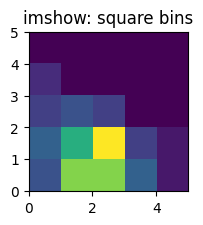

In [24]:
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [25]:
H

array([[ 4., 13., 13.,  5.,  1.],
       [ 5., 10., 16.,  3.,  1.],
       [ 3.,  4.,  3.,  0.,  0.],
       [ 2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [21]:
H.flatten()

array([ 7., 47., 11.,  3., 10.,  2.,  0.,  0.,  1.,  0.,  0.,  0.])

In [7]:
npoints = 10000
np.random.seed(2021)
x = np.random.rand(npoints)*10 - 3
y = np.random.rand(npoints)*5 - 3
z = gaussian2d(x, y, amplitude=30, centerx=2, centery=-.5, sigmax=.6, sigmay=.8)

print(z, len(z))
z += 2*(np.random.rand(*z.shape)-.5)
error = np.sqrt(z+1)

[6.49350451e-01 3.48723695e-03 4.60409548e-08 ... 1.96515497e-09
 2.51390877e-07 1.00562043e-02] 10000


In [2]:
data = pd.read_csv('./CentralDogma/2_Lust_/3-2MASSv2.csv')

n1 = 'RAJ2000'
n2 = 'DEJ2000'

# n1 = 'RAdeg'
# n2 = 'DEdeg'


In [3]:
fitrange = 60
grid = 80

x = (data.RA-data[n1])
y = (data.DEC-data[n2])

data = data.loc[(x>-0.02)&(x<0.02)&(y>-0.02)&(y<0.02),
                ['RA', 'DEC', n1, n2]
                ]

x = (data.RA-data[n1])*3600*np.cos(data.DEC*np.pi/180)
y = (data.DEC-data[n2])*3600

xedges = np.linspace(-fitrange, fitrange, grid)
yedges = np.linspace(-fitrange, fitrange, grid)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
H = H.T

# fig = plt.figure(figsize=(20, 15))
# ax = fig.add_subplot(131, title='imshow: square bins')
# plt.imshow(H, interpolation='nearest', origin='lower',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [4]:
z = H.flatten()

X, Y = np.meshgrid(np.linspace(-fitrange, fitrange, grid-1), np.linspace(-fitrange, fitrange, grid-1))
xf = X.flatten()
yf = Y.flatten()
# error = np.sqrt(z+1)
w = z**0.9+0.5

model = lmfit.models.Gaussian2dModel()
params = model.guess(z, xf, yf)
result = model.fit(z, x=xf, y=yf, params=params, weights=w/10)
# lmfit.report_fit(result)

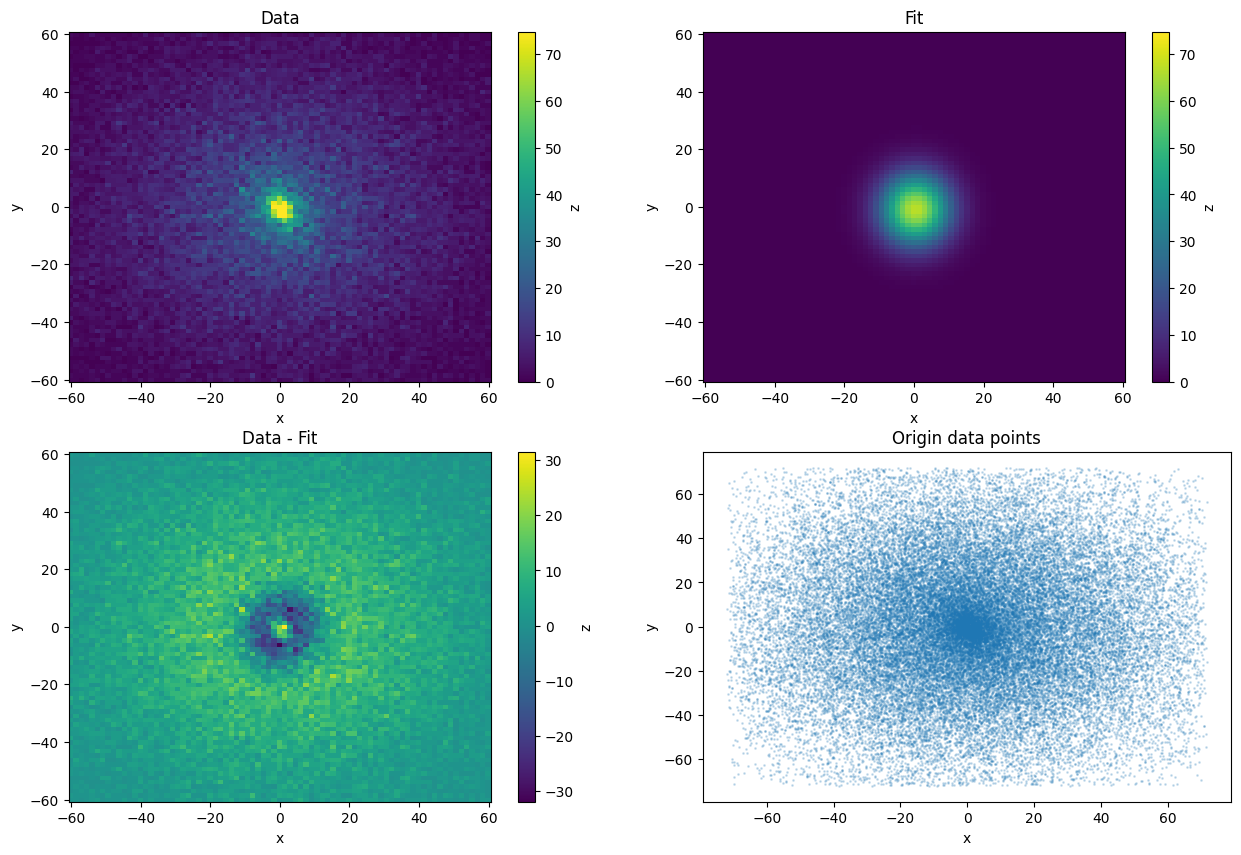

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

Z = griddata((xf, yf), z, (X, Y), method='linear', fill_value=0)

vmax = np.nanpercentile(Z, 99.9)

ax = axs[0, 0]
art = ax.pcolor(X, Y, Z, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data')

ax = axs[0, 1]
fit = model.func(X, Y, **result.best_values)
art = ax.pcolor(X, Y, fit, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Fit')

ax = axs[1, 0]
fit = model.func(X, Y, **result.best_values)
art = ax.pcolor(X, Y, Z-fit, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data - Fit')

ax = axs[1, 1]
ax.scatter(
    x, y,
    s = 1,
    alpha=0.2
)
ax.set_title('Origin data points')

for ax in axs.ravel():
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
plt.show()

In [49]:
result.values['sigmax']

6.998603057976281

In [42]:
 lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 182
    # data points      = 6241
    # variables        = 5
    chi-square         = 467579.513
    reduced chi-square = 74.9806787
    Akaike info crit   = 26948.8333
    Bayesian info crit = 26982.5278
    R-squared          = -0.55699215
[[Variables]]
    amplitude:  25555.6385 +/- 330.085145 (1.29%) (init = 39200)
    centerx:    0.59846322 +/- 0.07199095 (12.03%) (init = 1.538462)
    centery:   -0.72172511 +/- 0.08832498 (12.24%) (init = 0)
    sigmax:     6.99860306 +/- 0.08274773 (1.18%) (init = 20)
    sigmay:     8.63875320 +/- 0.10152372 (1.18%) (init = 20)
    fwhmx:      16.4804505 +/- 0.19485602 (1.18%) == '2.3548200*sigmax'
    fwhmy:      20.3427085 +/- 0.23907010 (1.18%) == '2.3548200*sigmay'
    height:     67.2735472 +/- 0.40210943 (0.60%) == '0.1591549*amplitude/(max(1e-15, sigmax)*max(1e-15, sigmay))'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigmax) = +0.611

In [32]:
help(result.best_values.values)

Help on built-in function values:

values(...) method of builtins.dict instance
    D.values() -> an object providing a view on D's values



ValueError: x and y must have same first dimension, but have shapes (79,) and (1,)

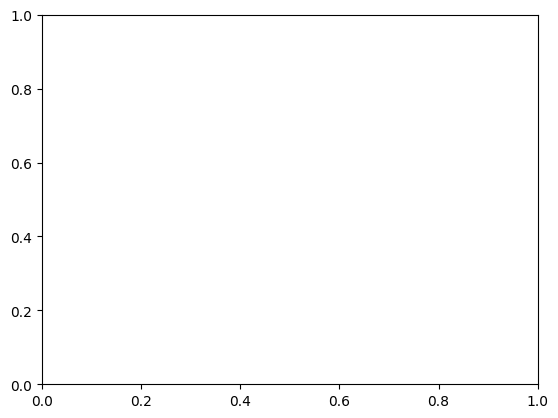

In [19]:
fig , ax = plt.subplots()

fit = model.func(X, **result.best_values)
ax.plot(X[0], result.best_fit[])

In [30]:
data = pd.read_csv('./CentralDogma/2_Lust_/3-2MASSv2.csv')

n1 = 'RAJ2000'
n2 = 'DEJ2000'

# n1 = 'RAdeg'
# n2 = 'DEdeg'

x = (data.RA-data[n1])
y = (data.DEC-data[n2])

data = data.loc[(x>-0.02)&(x<0.02)&(y>-0.02)&(y<0.02),
                ['RA', 'DEC', n1, n2]
                ]

x = (data.RA-data[n1])*3600*np.cos(data.DEC*np.pi/180)
y = (data.DEC-data[n2])*3600

print(len(x), len(y))

grid = 200

# x = x[:(grid-1)**2]
# y = y[:(grid-1)**2]

xedges = np.linspace(-70, 70, grid)
yedges = np.linspace(-70, 70, grid)

H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
H = H.T
H = H.flatten()
len(H)

46538 46538


39601

In [32]:
X, Y = np.meshgrid(np.linspace(-70, 70, grid),
                   np.linspace(-70, 70, grid))
Z = griddata((x, y), H, (X, Y), method='linear', fill_value=0)

fig, ax = plt.subplots()
art = ax.pcolor(X, Y, Z, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

ValueError: different number of values and points

In [31]:
x_data = x
y_data = y

def gaussian_2d(xy, A, x0, y0, sigma_x, sigma_y):
    x, y = xy
    return A * np.exp(-(x - x0)**2 / (2 * sigma_x**2) - (y - y0)**2 / (2 * sigma_y**2))

xy_data = np.array([x_data, y_data])

# Define the bin size for the 2D histogram
bin_size = 0.1  # Adjust this based on your data

# Create a 2D histogram to compute the density
hist, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=[np.arange(0, 1 + bin_size, bin_size),
                                                              np.arange(0, 1 + bin_size, bin_size)])

# Compute the density as the values in the histogram
z_data = hist.flatten()

# Initial guess for the parameters (you can adjust these based on your data)
initial_guess = [1.0, 1, 1, 0.1, 0.1]

# Perform the fit
popt, _ = curve_fit(gaussian_2d, xy_data, z_data, p0=initial_guess)

# Generate a grid of points for plotting the fitted Gaussian
x_range = np.linspace(0, 10, 100)
y_range = np.linspace(0, 10, 100)
xx, yy = np.meshgrid(x_range, y_range)
fitted_data = gaussian_2d((xx, yy), *popt)

# Plot the data density and the fitted Gaussian
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, c=z_data, cmap='viridis', s=50, edgecolors='k')
plt.contour(xx, yy, fitted_data.reshape(xx.shape), levels=[0.01], colors='red')
plt.colorbar()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Gaussian Fit with Density')
plt.show()


ValueError: operands could not be broadcast together with shapes (46538,) (100,) 

In [11]:
len(z_data)

2950